## A CNN Model for iris detection in an eye image

### Step:01 (Importing dependencies)

In [1]:
!pip install tensorflow tensorflow-gpu matplotlib albumentations

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e4/14/d795bb156f8cc10eb1dcfe1332b7dbb8405b634688980aa9be8f885cc888/tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [58 lines of output]
      Traceback (most recent call last):
        File "C:\Users\ninja\AppData\Local\Temp\pip-build-env-89alwtah\overlay\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\ninja\AppData\Local\Temp\pip-build-env-89alwtah\overlay\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\ninja\AppData\Local\Temp\pip-build-env-89alwtah\overlay\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _

In [2]:
pip list

Package           Version
----------------- -----------
asttokens         2.4.1
colorama          0.4.6
comm              0.2.1
debugpy           1.8.1
decorator         5.1.1
executing         2.0.1
ipykernel         6.29.3
ipython           8.22.2
jedi              0.19.1
jupyter_client    8.6.0
jupyter_core      5.7.1
matplotlib-inline 0.1.6
nest-asyncio      1.6.0
numpy             1.26.4
opencv-python     4.9.0.80
packaging         24.0
pandas            2.2.1
parso             0.8.3
pip               23.2.1
platformdirs      4.2.0
prompt-toolkit    3.0.43
psutil            5.9.8
pure-eval         0.2.2
Pygments          2.17.2
python-dateutil   2.9.0.post0
pytz              2024.1
pywin32           306
pyzmq             25.1.2
setuptools        65.5.0
six               1.16.0
stack-data        0.6.3
tornado           6.4
traitlets         5.14.1
tzdata            2024.1
wcwidth           0.2.13
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import time
import uuid
import cv2


In [5]:
uuid.uuid1()

UUID('4510bcf7-d34e-11ee-9721-1062e5e49eb6')

In [2]:
!labelme


2024-03-10 23:50:18,535 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Subhadeep\.labelmerc


###  STEP:02 (Review Dataset and Build image loading Fn)

In [3]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt


In [3]:
import torch

if torch.cuda.is_available():
    print("Available")
else:
    print("Not Availble")

Available


In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

x = torch.randn(10, 10).to(device)

In [4]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    

In [6]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
images= tf.data.Dataset.list_files(r"C:\Users\ninja\OneDrive\Desktop\Capstone\Images\*.jpg", shuffle=False)

In [5]:
images.as_numpy_iterator().next()

b'C:\\Users\\ninja\\OneDrive\\Desktop\\Capstone\\Images\\S1005L01.jpg'

In [6]:
def load_image(x):
    byte_img= tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_img)
    return img

In [25]:
images= images.map(load_image)

In [26]:
images.as_numpy_iterator().next()

array([[[179],
        [182],
        [182],
        ...,
        [133],
        [131],
        [133]],

       [[179],
        [182],
        [183],
        ...,
        [131],
        [128],
        [128]],

       [[182],
        [184],
        [184],
        ...,
        [132],
        [128],
        [126]],

       ...,

       [[200],
        [199],
        [199],
        ...,
        [239],
        [239],
        [239]],

       [[202],
        [202],
        [202],
        ...,
        [238],
        [238],
        [239]],

       [[213],
        [213],
        [212],
        ...,
        [239],
        [241],
        [242]]], dtype=uint8)

In [27]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [28]:
image_generator=images.batch(4).as_numpy_iterator()

In [31]:
plot_images=image_generator.next()

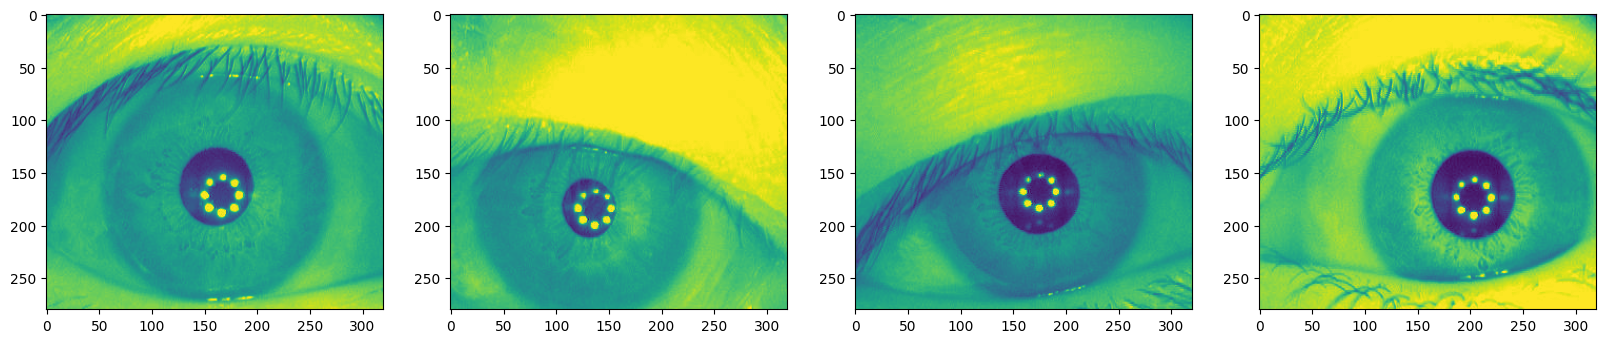

In [32]:
fig, ax= plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

### Step: 03 (Partition of Unaugmented Data)

In [33]:
for folder in ['Train','Test','Val']:
    for file in os.listdir(os.path.join(r"C:\Users\ninja\OneDrive\Desktop\Capstone\Partition", folder,'images')):
        filename=file.split('.')[0]+'.json'
        existing_filepath= os.path.join(r"C:\Users\ninja\OneDrive\Desktop\Capstone\Partition",'Labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath= os.path.join(r"C:\Users\ninja\OneDrive\Desktop\Capstone\Partition", folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)

### Step: 04(Image Augmentation on Images and Labels)

In [7]:
import albumentations as alb

In [57]:
augmentor = alb.Compose([alb.Resize(width=450, height=450),
                         alb.RandomCrop(width=320, height=280),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.1), 
                         alb.RGBShift(p=0.2)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [42]:
img = cv2.imread(os.path.join(r"C:\Users\ninja\OneDrive\Desktop\Capstone\Partition","Train", "images","file10.jpg"))

In [43]:
cv2.imshow("image",img)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [44]:
with open(os.path.join(r"C:\Users\ninja\OneDrive\Desktop\Capstone\Partition","Train","labels","file10.json"), 'r') as f:
    label = json.load(f)

In [46]:
p1=label['shapes'][0]['points'][:1]
#p2=label['shapes'][1]['points'][:1]


In [47]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [209]:
'''coords2 = [0,0,0,0]
coords2[0] = label['shapes'][1]['points'][0][0]
coords2[1] = label['shapes'][1]['points'][0][1]
coords2[2] = label['shapes'][1]['points'][1][0]
coords2[3] = label['shapes'][1]['points'][1][1]'''

"coords2 = [0,0,0,0]\ncoords2[0] = label['shapes'][1]['points'][0][0]\ncoords2[1] = label['shapes'][1]['points'][0][1]\ncoords2[2] = label['shapes'][1]['points'][1][0]\ncoords2[3] = label['shapes'][1]['points'][1][1]"

In [48]:
label

{'version': '5.4.1',
 'flags': {},
 'shapes': [{'label': 'iris',
   'points': [[142.0388349514563, 145.17799352750808],
    [223.2686084142395, 214.4336569579288]],
   'group_id': None,
   'description': '',
   'shape_type': 'circle',
   'flags': {},
   'mask': None},
  {'label': 'pupil',
   'points': [[147.8640776699029, 145.8252427184466],
    [182.81553398058253, 179.80582524271844]],
   'group_id': None,
   'description': '',
   'shape_type': 'circle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\CNN input\\file10.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAEYAUABAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APQ41OSTU7

In [49]:
coords[:2]

[142.0388349514563, 145.17799352750808]

In [212]:
#coords2[:2]

In [50]:
#  (x − h)2 + (y − k)2 = r2
import math
ri= math.sqrt((coords[2]-coords[0])**2 + (coords[3]-coords[1])**2 )
print(ri)

106.74559950650328


In [214]:
# rp= math.sqrt((coords2[2]-coords2[0])**2 + (coords2[3]-coords2[1])**2 )
# print(rp)

In [51]:
coords = list(np.divide(coords, [640,480,640,480]))
print(coords)

[0.22193567961165045, 0.3024541531823085, 0.34885720064724923, 0.44673678532901834]


In [216]:
# coords2 = list(np.divide(coords2, [640,480,640,480]))
# print(coords2)

In [58]:
augmented= augmentor(image=img, bboxes=[coords], class_labels=['iris'])

In [218]:
#augmented2= augmentor(image=img, bboxes=[coords2], class_labels=['pupil'])

In [59]:
augmented['bboxes']

[(0.22193567961165045,
  0.3024541531823085,
  0.34885720064724923,
  0.44673678532901834)]

In [220]:
#augmented2['bboxes']

In [60]:
tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int))

(99, 136)

In [61]:
tuple(np.multiply(augmented2['bboxes'][0][:2], [450,450]).astype(int))

NameError: name 'augmented2' is not defined

In [62]:
ri=int(ri)
#rp=int(rp)
print(ri)
#print(rp)

106


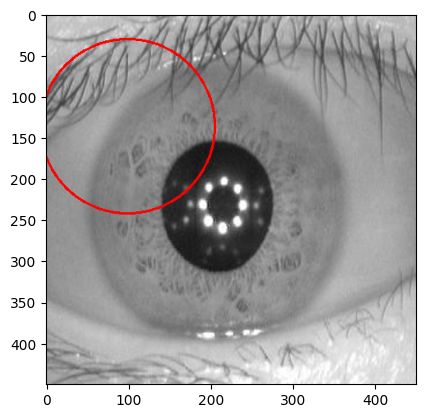

In [63]:
cv2.circle(augmented['image'], 
            tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              ri,(255,0,0), 2)
'''cv2.circle(augmented['image'], 
            tuple(np.multiply(augmented2['bboxes'][0][:2], [450,450]).astype(int)),
              rp,(0,255,0), 2)'''

plt.imshow(augmented['image'])

### Step: 05(Build and Run Augmentation Pipeline)

In [224]:
for partition in ["Train","Test","Val"]: 
    for image in os.listdir(os.path.join(r"D:\New_Programming\CAPSTONE\self_model", partition, "images")):
        img = cv2.imread(os.path.join(r"D:\New_Programming\CAPSTONE\self_model", partition, "images", image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join(r"D:\New_Programming\CAPSTONE\self_model", partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['iris'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Requested crop size (450, 450) is larger than the image size (238, 320)
Requested crop size (450, 450) is larger than the image size (238, 320)
Requested crop size (450, 450) is larger than the image size (194, 259)
y_max is less than or equal to y_min for bbox [0.41654608463035026, 0.33795395590142674, 0.44998480058365764, 0.11665045395590143, 'iris'].
Requested crop size (450, 450) is larger than the image size (280, 320)
Requested crop size (450, 450) is larger than the image size (280, 320)
Requested crop size (450, 450) is larger than the image size (280, 320)
Requested crop size (450, 450) is larger than the image size (280, 320)
Requested crop size (450, 450) is larger than the image size (280, 320)
Requested crop size (450, 450) is larger than the image size (280, 320)
x_max is less than or equal to x_min for bbox [0.4918440934065934, 0.448489010989011, 0.480683379120879, 0.6110347985347986, 'iris'].
Requested crop size (450, 450) is larger than the image size (238, 320)
Reques

In [88]:
import os
import shutil

# Define the folder containing the images
folder_path = r"D:\New_Programming\CAPSTONE\testing\images"

# Loop through all files in the folder
for filename in os.listdir(folder_path):
  # Check if the file is a JPEG image
  if filename.lower().endswith(".jpeg"):
    # Extract the filename without extension
    new_filename = os.path.splitext(filename)[0] + ".jpg"
    
    # Create the full path to the new and old files
    old_path = os.path.join(folder_path, filename)
    new_path = os.path.join(folder_path, new_filename)
    
    # Rename the file
    shutil.move(old_path, new_path)

    print(f"Converted {filename} to {new_filename}")


Converted WhatsApp Image 2024-03-01 at 23.13.58 (1).jpeg to WhatsApp Image 2024-03-01 at 23.13.58 (1).jpg
Converted WhatsApp Image 2024-03-01 at 23.13.58 (2).jpeg to WhatsApp Image 2024-03-01 at 23.13.58 (2).jpg
Converted WhatsApp Image 2024-03-01 at 23.13.58 (3).jpeg to WhatsApp Image 2024-03-01 at 23.13.58 (3).jpg
Converted WhatsApp Image 2024-03-01 at 23.13.58 (4).jpeg to WhatsApp Image 2024-03-01 at 23.13.58 (4).jpg
Converted WhatsApp Image 2024-03-01 at 23.13.58 (5).jpeg to WhatsApp Image 2024-03-01 at 23.13.58 (5).jpg
Converted WhatsApp Image 2024-03-01 at 23.13.58.jpeg to WhatsApp Image 2024-03-01 at 23.13.58.jpg
Converted WhatsApp Image 2024-03-01 at 23.13.59 (1).jpeg to WhatsApp Image 2024-03-01 at 23.13.59 (1).jpg
Converted WhatsApp Image 2024-03-01 at 23.13.59 (2).jpeg to WhatsApp Image 2024-03-01 at 23.13.59 (2).jpg
Converted WhatsApp Image 2024-03-01 at 23.13.59 (3).jpeg to WhatsApp Image 2024-03-01 at 23.13.59 (3).jpg
Converted WhatsApp Image 2024-03-01 at 23.13.59 (4).jp

In [9]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [95]:
train_images = tf.data.Dataset.list_files(r"D:\New_Programming\CAPSTONE\aug_data\Train\images\*.jpg", shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [89]:
test_images = tf.data.Dataset.list_files(r"D:\New_Programming\CAPSTONE\aug_data\Test\images\*.jpg", shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

(450, 450, 3)


In [97]:
image = next(test_images.as_numpy_iterator())
image_shape = image.shape
print(image_shape)

(120, 120, 3)


In [92]:
import os
import cv2

# Define the folder containing the images
folder_path = r"D:\New_Programming\CAPSTONE\testing\images"
# Get a list of all image filenames in the folder
image_files = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]
#print(image_files)
# Loop through each image file
for image_file in image_files:
    # Read the image
    image_path = os.path.join(folder_path, image_file)
    img = cv2.imread(image_path)
    print(img.shape)
    num_channels = img.shape[2] if len(img.shape) == 3 else 1
    if num_channels == 3:
        print("Image is in RGB format")
    elif num_channels == 1:
        print("Image is in grayscale format")
        # Convert grayscale to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        # Save the converted image
        cv2.imwrite(image_path, img_rgb)
    else:
        print("Image is in another format")

(240, 320, 3)
Image is in RGB format
(240, 320, 3)
Image is in RGB format
(280, 320, 3)
Image is in RGB format
(280, 320, 3)
Image is in RGB format
(280, 320, 3)
Image is in RGB format
(280, 320, 3)
Image is in RGB format
(281, 429, 3)
Image is in RGB format
(280, 320, 3)
Image is in RGB format
(280, 320, 3)
Image is in RGB format
(280, 320, 3)
Image is in RGB format
(280, 320, 3)
Image is in RGB format
(280, 320, 3)
Image is in RGB format
(280, 320, 3)
Image is in RGB format
(240, 320, 3)
Image is in RGB format
(280, 320, 3)
Image is in RGB format


In [94]:
def load_image2(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    
    # Ensure RGB format
    img = tf.cond(tf.shape(img)[-1] == 1,
                  lambda: tf.image.grayscale_to_rgb(img),
                  lambda: img)
    
    return img

In [95]:
test_images2 = tf.data.Dataset.list_files(r"D:\New_Programming\CAPSTONE\testing\images\*.jpg", shuffle=False)
test_images2 = test_images2.map(load_image2)
test_images2 = test_images2.map(lambda x: tf.image.resize(x, (120,120)))
test_images2 = test_images2.map(lambda x: x/255)

(240, 320, 3)


In [96]:
image = next(test_images2.as_numpy_iterator())
image_shape = image.shape
print(image_shape)

(120, 120, 3)


In [13]:
val_images = tf.data.Dataset.list_files(r"D:\New_Programming\CAPSTONE\aug_data\Val\images\*.jpg", shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [76]:
image = next(test_images2.as_numpy_iterator())

image_shape = image.shape
print(image_shape)

(120, 120, 3)


In [98]:
test_images2.as_numpy_iterator().next()

array([[[0.89738566, 0.89738566, 0.89738566],
        [0.90392154, 0.90392154, 0.90392154],
        [0.8352941 , 0.8352941 , 0.8352941 ],
        ...,
        [0.85392153, 0.85392153, 0.85392153],
        [0.9313725 , 0.9313725 , 0.9313725 ],
        [0.89803827, 0.89803827, 0.89803827]],

       [[0.89444447, 0.89444447, 0.89444447],
        [0.85      , 0.85      , 0.85      ],
        [0.80816996, 0.80816996, 0.80816996],
        ...,
        [0.8745096 , 0.8745096 , 0.8745096 ],
        [0.85882354, 0.85882354, 0.85882354],
        [0.87287563, 0.87287563, 0.87287563]],

       [[0.8947713 , 0.8947713 , 0.8947713 ],
        [0.8401961 , 0.8401961 , 0.8401961 ],
        [0.8169935 , 0.8169935 , 0.8169935 ],
        ...,
        [0.8558824 , 0.8558824 , 0.8558824 ],
        [0.8862745 , 0.8862745 , 0.8862745 ],
        [0.885294  , 0.885294  , 0.885294  ]],

       ...,

       [[0.8722222 , 0.8722222 , 0.8722222 ],
        [0.80588233, 0.80588233, 0.80588233],
        [0.8382353 , 0

In [99]:
test_images.as_numpy_iterator().next()


array([[[0.16715686, 0.13186274, 0.13578431],
        [0.17254902, 0.13725491, 0.14117648],
        [0.17205882, 0.1367647 , 0.14068627],
        ...,
        [0.35281864, 0.31752452, 0.3214461 ],
        [0.33529413, 0.3       , 0.30392158],
        [0.35851717, 0.32322302, 0.3271446 ]],

       [[0.17352942, 0.1382353 , 0.14215687],
        [0.17310049, 0.13780637, 0.14172794],
        [0.18878676, 0.15349264, 0.15741421],
        ...,
        [0.35631126, 0.32101715, 0.3249387 ],
        [0.3627451 , 0.327451  , 0.33137256],
        [0.36574754, 0.33045343, 0.334375  ]],

       [[0.17892157, 0.14362745, 0.14754902],
        [0.1764706 , 0.14117648, 0.14509805],
        [0.1882353 , 0.15294118, 0.15686275],
        ...,
        [0.39019608, 0.35490197, 0.35882354],
        [0.38039216, 0.34509805, 0.34901962],
        [0.37616423, 0.3408701 , 0.34479168]],

       ...,

       [[0.21011029, 0.17481618, 0.17873774],
        [0.23082107, 0.19552696, 0.19944853],
        [0.2538603 , 0

### Step: 06(Preparing the Labels)

In [109]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [26]:
train_labels= tf.data.Dataset.list_files(r"D:\New_Programming\CAPSTONE\aug_data\Train\labels\*.json", shuffle=False)
train_labels=train_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [110]:
test_labels= tf.data.Dataset.list_files(r"D:\New_Programming\CAPSTONE\aug_data\Test\labels\*.json", shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [28]:
val_labels= tf.data.Dataset.list_files(r"D:\New_Programming\CAPSTONE\aug_data\Val\labels\*.json", shuffle=False)
val_labels=val_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [29]:
val_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.9233, 0.2769, 0.932 , 0.5015], dtype=float16))

### Step: 07(Combine Label and Image Samples)

In [30]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3840, 3840, 360, 360, 240, 240)

In [100]:
len(test_images2)

15

In [31]:
train = tf.data.Dataset.zip((train_images, train_labels))

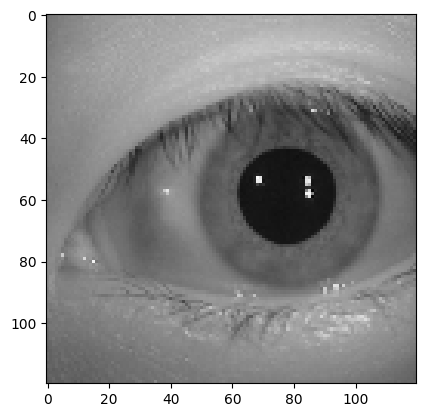

In [32]:
plt.imshow(train.as_numpy_iterator().next()[0])

In [33]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [155]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(800)
test = test.batch(8)
test = test.prefetch(4)

In [154]:
test2 = test_images2.shuffle(40)
test2 = test2.batch(8)
test2 = test2.prefetch(4)

In [35]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(500)
val = val.batch(8)
val = val.prefetch(4)

In [169]:
len(test.as_numpy_iterator().next()[0][0])

120

In [37]:
data_samples = train.as_numpy_iterator()

In [38]:
res = data_samples.next()

In [40]:
#print(res[0][0][0])
print(res[1][1][0])

[1]


In [42]:
import math

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.1293 0.3013]
27
[0.3223 0.4043]
25
[0.5356 0.7134]
27
[0.6743 0.4277]
25


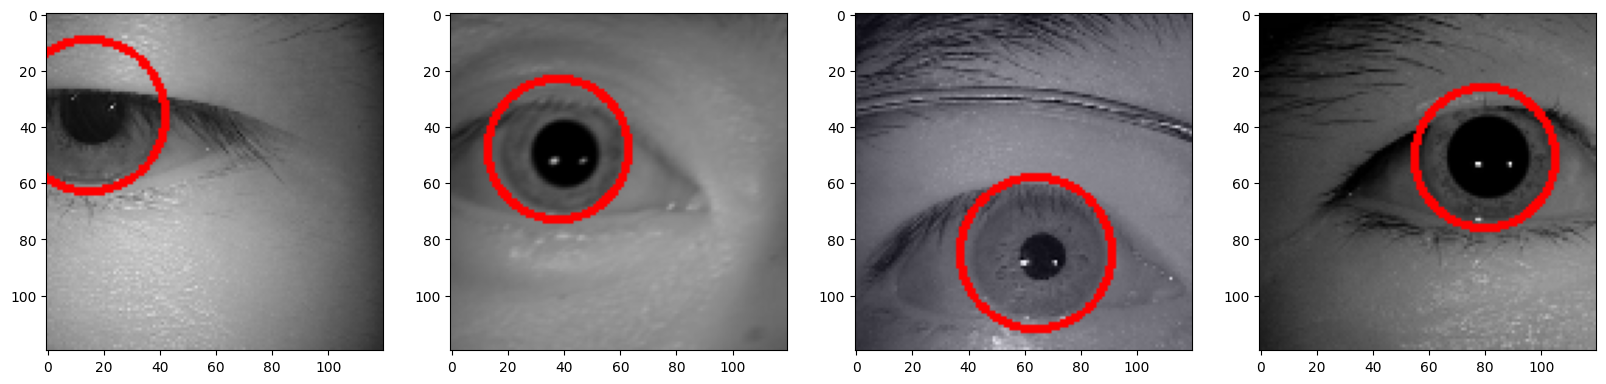

In [44]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    print(sample_coords[:2])
    #[640,480,640,480]
    r= math.sqrt(((sample_coords[2]*(120/480)*640)-(sample_coords[0]*(120/480)*640))**2 + ((sample_coords[3]*(120/480)*480)-(sample_coords[1]*(120/480)*480))**2 )
    r=int(r)
    print(r)
    writable_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)  # Convert to writable format
    cv2.circle(writable_image, tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)), r, (255, 0, 0), 2)
    '''
    cv2.circle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),r,
                        (255,0,0), 2)'''

    ax[idx].imshow(writable_image)


### Step: 08(Building Deep Learning model)

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [54]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

In [57]:
vgg = VGG16(include_top=False)

NameError: name 'VGG16' is not defined

In [55]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_16 (Conv2D)          (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_18 (Conv2D)          (None, 2, 2, 256)         262400    
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 256)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 1, 4)          

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

ValueError: decay is deprecated in the new Keras optimizer, please check the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.Adam.

In [246]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [247]:
facetracker = build_model()

In [248]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [249]:
X, y = train.as_numpy_iterator().next()

In [250]:
X.shape

(8, 120, 120, 3)

In [251]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 2s 2s/step


In [252]:
classes, coords

(array([[0.3331787 ],
        [0.38825232],
        [0.34545562],
        [0.34155273],
        [0.33843675],
        [0.2886032 ],
        [0.32632157],
        [0.3842811 ]], dtype=float32),
 array([[0.51438105, 0.43598896, 0.63408124, 0.6151735 ],
        [0.45954227, 0.541393  , 0.63176966, 0.6525142 ],
        [0.4308931 , 0.51924694, 0.69717634, 0.61100847],
        [0.44253904, 0.50920916, 0.6476661 , 0.611271  ],
        [0.45006174, 0.51151526, 0.71035194, 0.6286283 ],
        [0.4667959 , 0.51468605, 0.70622253, 0.6239243 ],
        [0.43604726, 0.5236058 , 0.72690755, 0.5701751 ],
        [0.50418574, 0.47272304, 0.6689648 , 0.6035033 ]], dtype=float32))

### Step: 09(Defining loses and optimiser)

In [253]:
batches_per_epoch = len(train)
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.0001,
    decay_steps=batches_per_epoch,
    decay_rate=(1./0.75 - 1),
)
#lr_decay = (1./0.75 -1)/batches_per_epoch

In [254]:
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [255]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [256]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [257]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=0.49642766>

In [258]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0730865>

In [259]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=0.49642766>

### Step: 10(Training our model)

In [260]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [261]:
model = FaceTracker(facetracker)

In [262]:
model.compile(opt, classloss, regressloss)

In [263]:
logdir='logs'

In [264]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [265]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
480/480 [==============================] - 1717s 4s/step - total_loss: 0.1106 - class_loss: 0.0207 - regress_loss: 0.1003 - val_total_loss: 0.0480 - val_class_loss: 1.8455e-04 - val_regress_loss: 0.0479
Epoch 2/10
395/480 [=======================>......] - ETA: 4:44 - total_loss: 0.0266 - class_loss: 0.0051 - regress_loss: 0.0240

2024-02-23 16:00:25,494 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Subhadeep\.labelmerc


480/480 [==============================] - 1674s 3s/step - total_loss: 0.0265 - class_loss: 0.0052 - regress_loss: 0.0239 - val_total_loss: 0.0362 - val_class_loss: 1.2626e-04 - val_regress_loss: 0.0361
Epoch 3/10
480/480 [==============================] - 1644s 3s/step - total_loss: 0.0205 - class_loss: 0.0042 - regress_loss: 0.0184 - val_total_loss: 0.1338 - val_class_loss: 0.0013 - val_regress_loss: 0.1332
Epoch 4/10
480/480 [==============================] - 1671s 3s/step - total_loss: 0.0179 - class_loss: 0.0038 - regress_loss: 0.0161 - val_total_loss: 0.0597 - val_class_loss: 9.3562e-05 - val_regress_loss: 0.0597
Epoch 5/10
480/480 [==============================] - 1625s 3s/step - total_loss: 0.0169 - class_loss: 0.0034 - regress_loss: 0.0152 - val_total_loss: 0.0274 - val_class_loss: 5.8020e-05 - val_regress_loss: 0.0274
Epoch 6/10
480/480 [==============================] - 1648s 3s/step - total_loss: 0.0143 - class_loss: 0.0026 - regress_loss: 0.0130 - val_total_loss: 0.0248 -

In [266]:
hist.history

{'total_loss': [0.00999963004142046,
  0.010824592784047127,
  0.00628992123529315,
  0.013213522732257843,
  0.002460573799908161,
  0.002766568446531892,
  0.004248735960572958,
  0.0037895289715379477,
  0.0005472289631143212,
  0.0008272732957266271],
 'class_loss': [0.00014511302288156003,
  0.0016987300477921963,
  0.000278102612355724,
  0.0005683263880200684,
  3.054847184102982e-05,
  1.3068527550785802e-05,
  2.0861732537014177e-06,
  0.00031588005367666483,
  2.8045264116371982e-05,
  2.9013426683377475e-05],
 'regress_loss': [0.009927073493599892,
  0.009975227527320385,
  0.006150870118290186,
  0.012929359450936317,
  0.00244529964402318,
  0.0027600342873483896,
  0.004247692879289389,
  0.003631589002907276,
  0.0005332063301466405,
  0.00081276660785079],
 'val_total_loss': [0.04795444384217262,
  0.03617525473237038,
  0.13384254276752472,
  0.05974424257874489,
  0.027425536885857582,
  0.024763358756899834,
  0.07692825794219971,
  0.04647311568260193,
  0.060191743

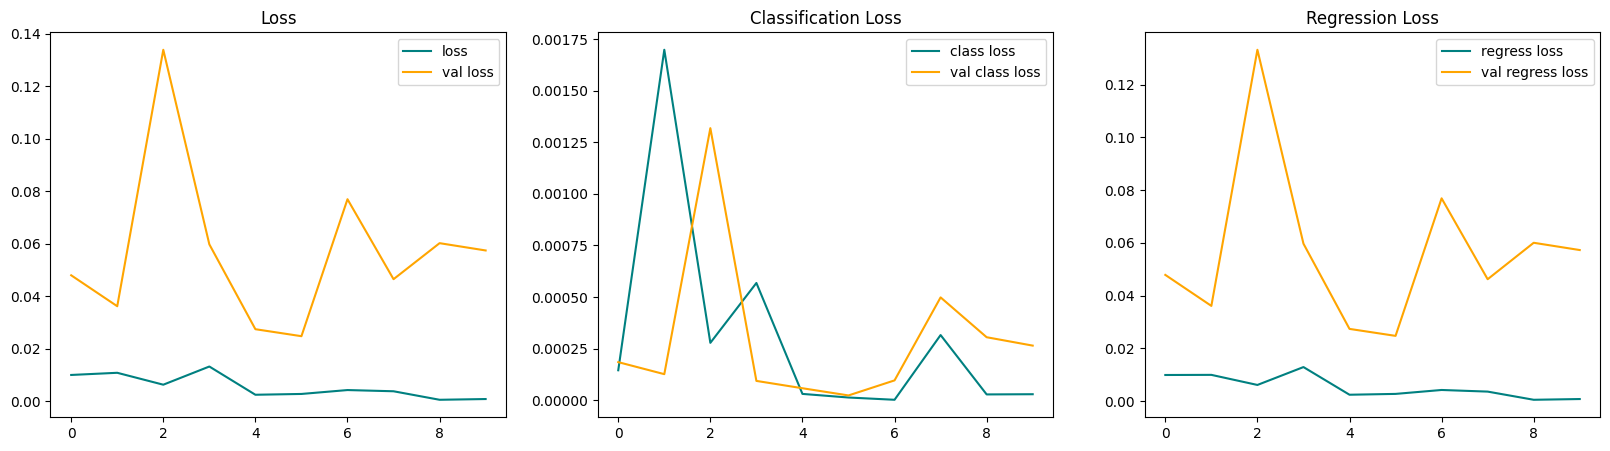

In [267]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

### Step: 11(Make Predictions)

In [229]:
test_data = test.as_numpy_iterator()

In [237]:
test_data2= test2.as_numpy_iterator()

In [238]:
test_sample2=test_data2.next()
print(type(test_sample2))
print(np.shape(test_sample2))
print(len(test_sample2))

<class 'numpy.ndarray'>
(8, 120, 120, 3)
8


In [230]:
test_sample = test_data.next()
print(type(test_sample[0]))
print(np.shape(test_sample[0]))
print(len(test_sample))

<class 'numpy.ndarray'>
(8, 120, 120, 3)
2


In [174]:
np.ndim(test_sample[0])

4

In [175]:
np.ndim(test_sample2)

4

In [176]:
from tensorflow.keras.models import load_model

In [177]:
facetracker = load_model('facetracker.h5')

In [207]:
test_sample2[0]    

array([[[0.89738566, 0.89738566, 0.89738566],
        [0.90392154, 0.90392154, 0.90392154],
        [0.8352941 , 0.8352941 , 0.8352941 ],
        ...,
        [0.85392153, 0.85392153, 0.85392153],
        [0.9313725 , 0.9313725 , 0.9313725 ],
        [0.89803827, 0.89803827, 0.89803827]],

       [[0.89444447, 0.89444447, 0.89444447],
        [0.85      , 0.85      , 0.85      ],
        [0.80816996, 0.80816996, 0.80816996],
        ...,
        [0.8745096 , 0.8745096 , 0.8745096 ],
        [0.85882354, 0.85882354, 0.85882354],
        [0.87287563, 0.87287563, 0.87287563]],

       [[0.8947713 , 0.8947713 , 0.8947713 ],
        [0.8401961 , 0.8401961 , 0.8401961 ],
        [0.8169935 , 0.8169935 , 0.8169935 ],
        ...,
        [0.8558824 , 0.8558824 , 0.8558824 ],
        [0.8862745 , 0.8862745 , 0.8862745 ],
        [0.885294  , 0.885294  , 0.885294  ]],

       ...,

       [[0.8722222 , 0.8722222 , 0.8722222 ],
        [0.80588233, 0.80588233, 0.80588233],
        [0.8382353 , 0

In [241]:
yhat = facetracker.predict(test_sample2)
print(yhat[1][0])

1/1 [==============================] - 2s 2s/step
[0.5115608  0.55713755 0.6080027  0.79461926]


In [231]:
yhat = facetracker.predict(test_sample[0])
print(yhat[1][0])

1/1 [==============================] - 2s 2s/step
[0.40341967 0.41474634 0.5082408  0.56598186]


In [198]:
test_sample2[0]

array([[[0.7518518 , 0.7518518 , 0.7518518 ],
        [0.75032675, 0.75032675, 0.75032675],
        [0.77298474, 0.77298474, 0.77298474],
        ...,
        [0.7686274 , 0.7686274 , 0.7686274 ],
        [0.75686276, 0.75686276, 0.75686276],
        [0.74575156, 0.74575156, 0.74575156]],

       [[0.73856205, 0.73856205, 0.73856205],
        [0.7529412 , 0.7529412 , 0.7529412 ],
        [0.78039217, 0.78039217, 0.78039217],
        ...,
        [0.76535946, 0.76535946, 0.76535946],
        [0.74509805, 0.74509805, 0.74509805],
        [0.7385622 , 0.7385622 , 0.7385622 ]],

       [[0.7522876 , 0.7522876 , 0.7522876 ],
        [0.7692811 , 0.7692811 , 0.7692811 ],
        [0.78344226, 0.78344226, 0.78344226],
        ...,
        [0.79912853, 0.79912853, 0.79912853],
        [0.74313724, 0.74313724, 0.74313724],
        [0.719826  , 0.719826  , 0.719826  ]],

       ...,

       [[0.6529411 , 0.6529411 , 0.6529411 ],
        [0.66209143, 0.66209143, 0.66209143],
        [0.66535944, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24
23
27
26


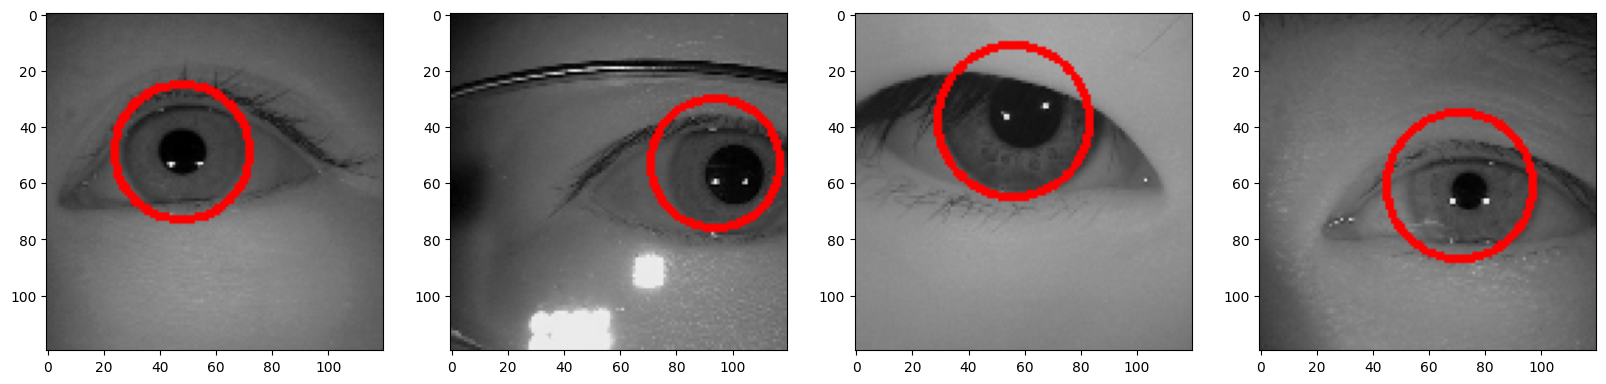

In [232]:
import math
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    r= math.sqrt(((sample_coords[2]*(120/480)*640)-(sample_coords[0]*(120/480)*640))**2 + ((sample_coords[3]*(120/480)*480)-(sample_coords[1]*(120/480)*480))**2 )
    r=int(r)
    print(r)
    if yhat[0][idx] > 0.9:
        writable_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)  # Convert to writable format
        cv2.circle(writable_image, tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)), r, (255, 0, 0), 2)
    
    ax[idx].imshow(writable_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32
30
31
30


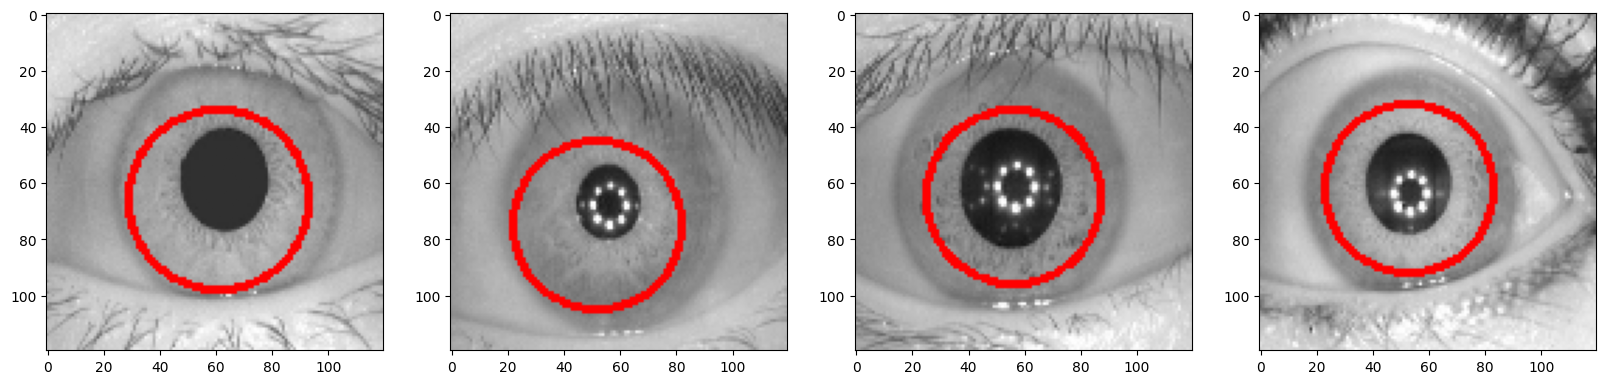

In [243]:
import math
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample2[idx]
    sample_coords = yhat[1][idx]
    r= math.sqrt(((sample_coords[2]*(120/480)*640)-(sample_coords[0]*(120/480)*640))**2 + ((sample_coords[3]*(120/480)*480)-(sample_coords[1]*(120/480)*480))**2 )
    r=int(r)
    print(r)
    if yhat[0][idx] > 0.9:
        writable_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)  # Convert to writable format
        cv2.circle(writable_image, tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)), r, (255, 0, 0), 2)
    
    ax[idx].imshow(writable_image)

### Step:12 (Running the model on a live feed)

In [233]:
from tensorflow.keras.models import load_model

In [234]:
facetracker.save('facetracker.h5')

c:\Users\Subhadeep\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [235]:
facetracker = load_model('facetracker.h5')

In [236]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    print(sample_coords[:2])
    r= math.sqrt(((sample_coords[2]*(120/480)*640)-(sample_coords[0]*(120/480)*640))**2 + ((sample_coords[3]*(120/480)*480)-(sample_coords[1]*(120/480)*480))**2 )
    r=int(r)
    print(tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)))
    print(r)
    if yhat[0] > 0.5: 
        
        #writable_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to writable format
        cv2.circle(rgb, tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)), r, (255, 0, 0), 2)
        #cv2.circle(rgb, tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),[0,-30])),r,(255,0,0), -1)
                   
        '''
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        '''
        # Controls the text rendered
        cv2.putText(rgb, 'iris', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', rgb)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 1s 536ms/step
[0.5755681  0.41299996]
(69, 49)
36
1/1 [==============================] - 0s 226ms/step
[0.55579    0.39753628]
(66, 47)
37
1/1 [==============================] - 0s 180ms/step
[0.56399393 0.38322738]
(67, 45)
36
1/1 [==============================] - 0s 213ms/step
[0.56317526 0.3946644 ]
(67, 47)
34
1/1 [==============================] - 0s 232ms/step
[0.5359013  0.38462475]
(64, 46)
33
1/1 [==============================] - 0s 227ms/step
[0.5343508  0.38168207]
(64, 45)
32
1/1 [==============================] - 0s 210ms/step
[0.50533986 0.3999948 ]
(60, 47)
27
1/1 [==============================] - 0s 233ms/step
[0.4849072 0.3766883]
(58, 45)
25
1/1 [==============================] - 0s 219ms/step
[0.5435521 0.3991265]
(65, 47)
29
1/1 [==============================] - 0s 248ms/step
[0.5762703  0.37768573]
(69, 45)
33
1/1 [==============================] - 0s 320ms/step
[0.5530387 0.4112777]
(66, 49)
34
1/1 [======================